<a href="https://colab.research.google.com/github/joey0320/reversemethod/blob/colabcodes_SingleSource_fixedX/RM_USING_EXCEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Apr 18 05:01:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [59]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
import cv2
#from DataCaller_Excel import DataCaller_Excel
#from Model import Net
#from EarlyStop import EarlyStopping

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
LOAD_DATA = False
BATCH_SIZE = 48
VAL_BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 1000
PATIENCE = 6
VALIDATE_EVERY = 10
MODEL_NAME = f"model-{int(time.time())}"
IMG_SIZE = 64
IMG_CHANNELS = 1
OUTPUT_LABEL_SIZE = 4
OUTPUT_AB = 2
OUTPUT_Y = 1
OUTPUT_D = 1

cuda


In [0]:

class DataCaller_Excel(Dataset):
    def __init__(self, data_path, inputsize):
        
        self.data_path = data_path
        self.inputsize = inputsize
        
        data = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet1', header=None)
        data = np.array(data)
        data = data.reshape(-1, 1, inputsize, inputsize)
        self.data = torch.from_numpy(data).float()
        
        label = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet2', header=None)
        self.label = torch.from_numpy( np.array(label) ).float()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.label[idx])
        return x, y

In [0]:

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = - val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Conv2d(16, 16, kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #32 x 32 x 16
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #16 x 16 x 32
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #8 x 8 x 64

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #4 x 4 x 128
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #2 x 2 x 256

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #1 x 1 x 512
            
        )
        self.fcc_ab = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, OUTPUT_AB)
        )
        self.fcc_xy = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(32, OUTPUT_Y)   
        )
        self.fcc_d = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, OUTPUT_D)
        )
    def forward(self, x):
        output = self.cnn(x)
        feature_map = output.view(output.size(0), -1)
        ab = self.fcc_ab(feature_map)
        a = ab[:, :1]
        b = ab[:, 1:]
        xy = self.fcc_xy(feature_map)
        d = self.fcc_d(feature_map)

        return a, b, xy, d

In [0]:
#data path
DRIVE_PATH = '/content/gdrive/My Drive/Colab Notebooks'
BASE_PATH = 'singlesource_regression_fixed_x'
TRAIN_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'train')
VAL_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'val')
TEST_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'test')
LOAD_PRETRAINED_PATH = os.path.join(DRIVE_PATH, 'Results', 'SingleSource_ByClasses_Fixed_X', 'traindata_Size_37250', 'checkpoint.pt')
#TRAIN_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'train')
#VAL_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'val')
#TEST_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'test')

In [0]:
if LOAD_DATA:
    trainsets = []
    valsets = []
    testsets = []
    for f in tqdm(os.listdir(TRAIN_PATH_LABEL)):
      path = os.path.join(TRAIN_PATH_LABEL, f)
      trainset = DataCaller_Excel(path, IMG_SIZE)
      print(trainset.__len__())
      trainsets.append(trainset)

    for f in tqdm(os.listdir(VAL_PATH_LABEL)):
      path  = os.path.join(VAL_PATH_LABEL, f)
      valset = DataCaller_Excel(path, IMG_SIZE)
      print(valset.__len__())
      valsets.append(valset)

    for f in tqdm(os.listdir(TEST_PATH_LABEL)):
      path  = os.path.join(TEST_PATH_LABEL, f)
      testset = DataCaller_Excel(path, IMG_SIZE)
      print(testset.__len__())
      testsets.append(testset)

    trainset = ConcatDataset(trainsets)
    print(trainset.__len__())
    valset = ConcatDataset(valsets)
    print(valset.__len__())
    testset = ConcatDataset(testsets)
    print(testset.__len__())
    #trainset = DataCaller(TRAIN_PATH_IMG, TRAIN_PATH_LABEL, IMG_SIZE)
    #valset = DataCaller(VAL_PATH_IMG, VAL_PATH_LABEL, IMG_SIZE)
    #testset = DataCaller(TEST_PATH_IMG, TEST_PATH_LABEL, IMG_SIZE)

In [0]:
#valsets = []
#for f in tqdm(os.listdir(VAL_PATH_LABEL)):
#  path  = os.path.join(VAL_PATH_LABEL, f)
#  valset = DataCaller_Excel(path, IMG_SIZE)
#  print(valset.__len__())
#  valsets.append(valset)

#valset = ConcatDataset(valsets)


In [0]:
#define dataloaders
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [66]:
#just checking if the data is loaded properly
cnt = 0
for i, data in enumerate(trainloader):
    x, y = data
    x = np.array(x)
    x = x.reshape(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
    #print(x)
    #x = x.astype(int)
    print(x)
    print(x[0].shape)
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1))
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1), cmap='gray')
    #plt.show()
    #print(x[0])
    print(y)
    cnt += 1
    if cnt==1:
      break

[[[[ -4.4710703   -4.812173    -5.9452753  ... -35.086098
    -35.272633   -35.471085  ]
   [ -4.4710703   -4.0361576   -4.707618   ... -39.508617
    -39.75702    -39.973923  ]
   [ -4.4710703   -3.6006918   -4.7236667  ... -35.815456
    -35.849007   -35.99788   ]
   ...
   [ -4.4710703   -7.62017    -14.060376   ... -36.21012
    -36.348225   -36.531662  ]
   [ -4.4710703   -5.9814076   -8.798595   ... -42.524273
    -42.572765   -42.721474  ]
   [ -4.4710703   -4.812173    -5.9452753  ... -35.086098
    -35.272633   -35.471085  ]]]


 [[[ -4.455067    -4.712638    -5.4820075  ... -36.34499
    -36.489464   -36.58942   ]
   [ -4.455067    -5.4984508   -8.605658   ... -29.53411
    -29.645878   -29.766745  ]
   [ -4.455067    -6.628226   -13.520862   ... -29.574326
    -29.484007   -29.536657  ]
   ...
   [ -4.455067    -4.0575657   -3.5749052  ... -35.092693
    -34.993362   -35.04858   ]
   [ -4.455067    -4.2392163   -3.9229133  ... -35.34475
    -35.387768   -35.474674  ]
   [ -4

In [0]:
def weighted_mse(input, target, weight):
  input = input.to(device)
  target = target.to(device)
  weight = weight.to(device)
  return torch.sum(weight * (input - target)**2)

In [0]:
def weighted_MSE(a, b, y, d, label_a, label_b, label_y, label_d, weight):
  a = a.to(device)
  b = b.to(device)
  y = y.to(device)
  d = d.to(device)

  label_a = label_a.to(device)
  label_b = label_b.to(device)
  label_y = label_y.to(device)
  label_d = label_d.to(device)

  weight = weight.to(device)
  
  a = a.view(len(a))
  b = b.view(len(b))
  y = y.view(len(y))
  d = d.view(len(d))

  crit1 = nn.MSELoss()
  crit2 = nn.MSELoss()
  crit3 = nn.MSELoss()
  crit4 = nn.MSELoss()

  return weight[0] * crit1(a, label_a) + weight[1] * crit2(b, label_b) + weight[2] * crit3(y, label_y) + weight[3] * crit4(d, label_d)

In [0]:

def get_loss(a, b, y, d, label_a, label_b, label_y, label_d, weight):
  # a,b : 1 x 21
  # xy : 1 x 2
  # d : 1 x 10
  a = a.to(device)
  b = b.to(device)
  y = y.to(device)
  d = d.to(device)

  y = y.view(len(y))

  weight = weight.to(device)

  #change shape and form of labels
  label_a = label_a.view(len(label_a))
  label_b = label_b.view(len(label_b))
  label_d = label_d.view(len(label_d))
  label_a = label_a.type(torch.cuda.LongTensor)
  label_b = label_b.type(torch.cuda.LongTensor)
  label_d = label_d.type(torch.cuda.LongTensor)

  label_y = label_y.view(len(label_y))

  # classes should be 0 ~ N - 1
  # class N means that the length is ( N + 1 ) * lambda 
  #x = torch.ones(len(label_a))
  #x = x.to(device)
  #x = x.type(torch.cuda.LongTensor)

  #label_a = label_a - x
  #label_b = label_b - x

  #y = torch.ones(len(label_d))
  #y = y.to(device)
  #y = y.type(torch.cuda.LongTensor)
  
  #label_d = label_d - y

  #define criterion
  crit1 = nn.CrossEntropyLoss()
  crit2 = nn.CrossEntropyLoss()
  crit3 = nn.MSELoss()
  crit4 = nn.CrossEntropyLoss()

  loss1 = crit1(a, label_a)
  loss2 = crit2(b, label_b)
  loss3 = crit3(y, label_y)
  loss4 = crit4(d, label_d)
  
  return loss1 * weight[0]  + loss2 * weight[1] + loss3 * weight[2] + loss4 * weight[3]



In [0]:
#train the model
def train(net, model_name, patience, validate_every):
    
    optimizer = optim.Adam(net.parameters(), LEARNING_RATE, betas=(0.9, 0.999), eps=1e-09, weight_decay=0, amsgrad=False)
    weight = torch.tensor([1.5, 1.5, 1.0, 2])

    train_losses = []
    val_losses = []
    avg_train_losses = []
    avg_val_losses = []

    #train_errors = []
    #val_errors = []

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    with open("model.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
                net.train()
                for batch_idx, samples in enumerate(trainloader):
                    x, y = samples
                    x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    x = x.to(device)
                    y = y.to(device)

                    la = y[:, 0]
                    lb = y[:, 1]
                    ly = y[:, 2]
                    ld = y[:, 3]

                    a, b, xy, d = net(x)
                    loss = weighted_MSE(a, b, xy, d, la, lb, ly, ld, weight)
                    net.zero_grad()
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.item())

                net.eval()
                for batch_idx, samples in enumerate(valloader):
                    x, y = samples
                    x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    x = x.to(device)
                    y = y.to(device)

                    la = y[:, 0]
                    lb = y[:, 1]
                    ly = y[:, 2]
                    ld = y[:, 3]

                    a, b, xy, d = net(x)
                    loss = weighted_MSE(a, b, xy, d, la, lb, ly, ld, weight)
                    val_losses.append(loss.item())

                train_loss = np.average(train_losses)
                valid_loss = np.average(val_losses)
                avg_train_losses.append(train_loss)
                avg_val_losses.append(valid_loss)
                

                train_losses = []
                val_losses = []


                f.write(f"{MODEL_NAME},{round(time.time(), 3)},  {round(float(train_loss), 4)},  {round(float(valid_loss),4)}\n")
                print("\nloss : ", train_loss, "val loss : ", valid_loss, "\n")
                
                early_stopping(valid_loss, net)
                
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
        # load the last checkpoint with the best model
        net.load_state_dict(torch.load('checkpoint.pt'))
        
        return avg_train_losses, avg_val_losses

In [0]:
net = Net()
#print(net)


In [72]:
net.to(device)
train_loss, valid_loss = train(net, MODEL_NAME, PATIENCE, VALIDATE_EVERY)




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 1/1000 [00:07<1:57:43,  7.07s/it]


loss :  659.0322009277344 val loss :  301.26892835828994 

Validation loss decreased (inf --> 301.268928).  Saving model ...





  0%|          | 2/1000 [00:14<1:57:42,  7.08s/it]


loss :  265.18160810990764 val loss :  185.46553080240886 

Validation loss decreased (301.268928 --> 185.465531).  Saving model ...





  0%|          | 3/1000 [00:21<1:57:17,  7.06s/it]


loss :  211.07736358642578 val loss :  122.21348151312934 

Validation loss decreased (185.465531 --> 122.213482).  Saving model ...





  0%|          | 4/1000 [00:28<1:57:00,  7.05s/it]


loss :  168.38484021273527 val loss :  95.34348748101128 

Validation loss decreased (122.213482 --> 95.343487).  Saving model ...





  0%|          | 5/1000 [00:35<1:56:54,  7.05s/it]


loss :  153.62947095003994 val loss :  91.73424782647027 

Validation loss decreased (95.343487 --> 91.734248).  Saving model ...





  1%|          | 6/1000 [00:42<1:56:57,  7.06s/it]


loss :  146.29701808582652 val loss :  82.0622181532118 

Validation loss decreased (91.734248 --> 82.062218).  Saving model ...





  1%|          | 7/1000 [00:49<1:56:39,  7.05s/it]


loss :  137.78132125854492 val loss :  92.97642534044054 

EarlyStopping counter: 1 out of 6





  1%|          | 8/1000 [00:56<1:56:18,  7.03s/it]


loss :  128.27292481855912 val loss :  42.007555118136935 

Validation loss decreased (82.062218 --> 42.007555).  Saving model ...





  1%|          | 9/1000 [01:03<1:56:08,  7.03s/it]


loss :  113.66841666481712 val loss :  49.68313976711697 

EarlyStopping counter: 1 out of 6





  1%|          | 10/1000 [01:10<1:56:10,  7.04s/it]


loss :  102.57639755249023 val loss :  28.39641748216417 

Validation loss decreased (42.007555 --> 28.396417).  Saving model ...





  1%|          | 11/1000 [01:17<1:55:50,  7.03s/it]


loss :  98.74600972955876 val loss :  58.91227386474609 

EarlyStopping counter: 1 out of 6





  1%|          | 12/1000 [01:24<1:55:46,  7.03s/it]


loss :  95.7861123310436 val loss :  23.55070525487264 

Validation loss decreased (28.396417 --> 23.550705).  Saving model ...





  1%|▏         | 13/1000 [01:31<1:55:52,  7.04s/it]


loss :  94.68924077120694 val loss :  21.048984926011826 

Validation loss decreased (23.550705 --> 21.048985).  Saving model ...





  1%|▏         | 14/1000 [01:38<1:56:01,  7.06s/it]


loss :  92.06341384194114 val loss :  15.400244314405652 

Validation loss decreased (21.048985 --> 15.400244).  Saving model ...





  2%|▏         | 15/1000 [01:45<1:55:42,  7.05s/it]


loss :  91.35531715393067 val loss :  18.905695203145346 

EarlyStopping counter: 1 out of 6





  2%|▏         | 16/1000 [01:52<1:55:15,  7.03s/it]


loss :  88.70718247153542 val loss :  36.35627641465929 

EarlyStopping counter: 2 out of 6





  2%|▏         | 17/1000 [01:59<1:55:02,  7.02s/it]


loss :  87.687720933394 val loss :  35.00399748908149 

EarlyStopping counter: 3 out of 6





  2%|▏         | 18/1000 [02:06<1:54:53,  7.02s/it]


loss :  87.03593197215687 val loss :  12.941650725470648 

Validation loss decreased (15.400244 --> 12.941651).  Saving model ...





  2%|▏         | 19/1000 [02:13<1:54:48,  7.02s/it]


loss :  85.66473914406517 val loss :  39.23825289408366 

EarlyStopping counter: 1 out of 6





  2%|▏         | 20/1000 [02:20<1:54:44,  7.03s/it]


loss :  84.50621790799228 val loss :  34.03335189819336 

EarlyStopping counter: 2 out of 6





  2%|▏         | 21/1000 [02:27<1:54:45,  7.03s/it]


loss :  84.07643750971013 val loss :  19.715183770921495 

EarlyStopping counter: 3 out of 6





  2%|▏         | 22/1000 [02:34<1:54:40,  7.03s/it]


loss :  82.93232230446556 val loss :  12.65861162185669 

Validation loss decreased (12.941651 --> 12.658612).  Saving model ...





  2%|▏         | 23/1000 [02:41<1:54:47,  7.05s/it]


loss :  81.38351866288619 val loss :  18.504952553643122 

EarlyStopping counter: 1 out of 6





  2%|▏         | 24/1000 [02:48<1:54:45,  7.06s/it]


loss :  81.7327974839644 val loss :  32.33711679246691 

EarlyStopping counter: 2 out of 6





  2%|▎         | 25/1000 [02:56<1:54:43,  7.06s/it]


loss :  81.0068977355957 val loss :  17.107863426208496 

EarlyStopping counter: 3 out of 6





  3%|▎         | 26/1000 [03:03<1:54:17,  7.04s/it]


loss :  79.24760052074086 val loss :  24.51580315907796 

EarlyStopping counter: 4 out of 6





  3%|▎         | 27/1000 [03:10<1:54:08,  7.04s/it]


loss :  80.7051233326305 val loss :  17.527181964450413 

EarlyStopping counter: 5 out of 6

loss :  78.62247737537731 val loss :  24.206098492940267 

EarlyStopping counter: 6 out of 6
Early stopping


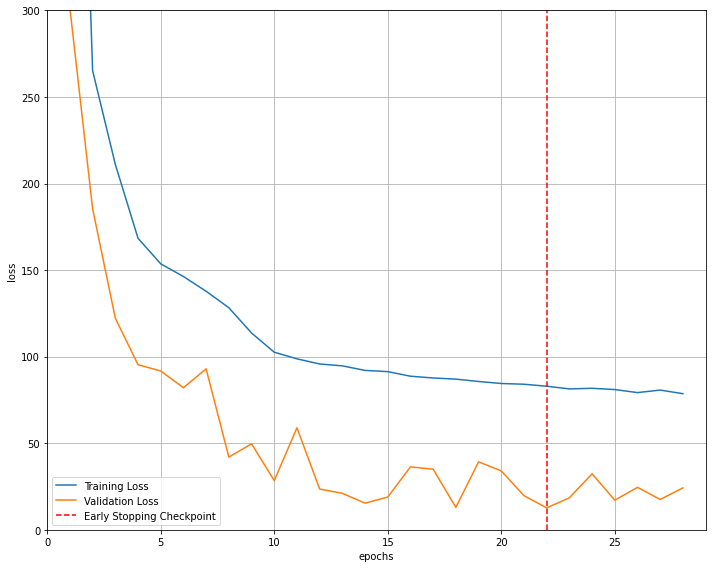

In [73]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 300) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [0]:
def test(net):
    predictions = []
    with torch.no_grad():
        for i, sample in enumerate(testloader):
            predict = []
            x ,y = sample
            x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
            
            x = x.to(device)
            y = y.to(device)
            
            a, b, xy, d = net(x)

            #get class of a, b, d
            #_, aa = a.max(1)
            #_, bb = b.max(1)
            #_, dd = d.max(1)

            final_result = torch.cat([a, b, xy, d], dim = 1)
            #print(final_result.shape)
            #print(type(final_result))
            final_result = final_result.to("cpu")
          
            predictions.append(final_result.numpy())
            

    print(predictions)
    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, OUTPUT_LABEL_SIZE)
    #print()
    #predictions = np.array(predictions)
    #predictions = predictions.reshape(-1, OUTPUT_LABEL_SIZE)
    df = DataFrame(predictions)
    df.to_excel('predictions.xlsx', header=None)

In [0]:
#for f in tqdm(os.listdir(TEST_PATH_LABEL)):
#  path  = os.path.join(TEST_PATH_LABEL, f)
# testset = DataCaller_Excel(path, IMG_SIZE)
#  print(testset.__len__())
#  testsets.append(testset)

#testset = ConcatDataset(testsets)

In [76]:
testloader = DataLoader(testset, batch_size=1, shuffle=False)
trained_net = Net()
trained_net.load_state_dict(torch.load('checkpoint.pt'))
trained_net.to(device)
trained_net.eval()
test(trained_net)

[array([[31.88322 , 13.140922, -7.457351, 37.387672]], dtype=float32), array([[23.590134 , 14.645549 , -6.4328866, 33.591053 ]], dtype=float32), array([[ 27.237152,  10.62564 , -15.979871,  25.410622]], dtype=float32), array([[59.685455, 91.484245, 45.79695 , 42.06288 ]], dtype=float32), array([[ 31.350555,  29.940262, -49.864967,  35.31233 ]], dtype=float32), array([[25.314802,  9.427336, -7.383525, 22.441982]], dtype=float32), array([[ 18.517744,  14.139503, -24.786173,  52.24604 ]], dtype=float32), array([[45.55709  , 15.192203 , -3.0359707, 39.397533 ]], dtype=float32), array([[ 26.297644,  15.564988, -36.232113,  48.603817]], dtype=float32), array([[34.830585 , 12.648577 , -5.0898023, 27.551006 ]], dtype=float32), array([[ 23.454912,  43.482006, -28.410223,  25.59731 ]], dtype=float32), array([[19.075043, 19.152477, 13.398307, 11.484597]], dtype=float32), array([[ 44.820644,  38.383812, -40.965855,  34.937283]], dtype=float32), array([[31.53859  , 10.581897 , -3.0559592, 22.685041

In [23]:
testloader = DataLoader(testset, batch_size=1, shuffle=False)
#trained_net = Net()
load_net.load_state_dict(torch.load(LOAD_PRETRAINED_PATH))
load_net.to(device)
load_net.eval()
test(load_net)

NameError: ignored